# Laboratory 2: Data Visualization for Large Structured Data

## If we have 5 million rows, can we just plot them?

* Visualization is NOT about plotting raw data.
* Visualization is about plotting aggregated insight.


Apache Parquet is a:
* column-based storage format
* Optimized for analytics
* Compressed
* Efficient for big data systems

Created for big data ecosystems like:
* Spark
* Hadoop
* Data Lakes
* Cloud analytics systems

## Row vs column-based format

Row-based: row1: col1 col2 col3 col4
Parquet (column-based): col1: values...   --> This is MASSIVE for performance.

## Step 1. Load dataset lazily (Polars + Parquet format)

## Dataset:Yellow Taxi Trip Records  https://data.cityofnewyork.us/Transportation/Yellow-Taxi-Trip-Records/4b4i-vvec
* The dataset is officially published by the NYC Taxi & Limousine Commission via the NYC Open Data portal.
* For programmatic access and performance reasons, we use the AWS CloudFront–hosted Parquet files, which allow efficient columnar and lazy processing.

In [10]:
import polars as pl

url_parquet = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"

df = pl.scan_parquet(url_parquet)  # lazy
df.select(pl.len()).collect()
df

## What doest scan_parquet()?

* Connects to the Parquet file
* Reads only the metadata
* Builds a logical query plan
* Does NOT load the data yet

## Exploratory Data Analysis (EDA)

In [11]:
len(df.schema), df.schema

C:\Users\sergi\AppData\Local\Temp\ipykernel_23248\1630882091.py:1: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  len(df.schema), df.schema


(19,
 Schema([('VendorID', Int64),
         ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
         ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
         ('passenger_count', Float64),
         ('trip_distance', Float64),
         ('RatecodeID', Float64),
         ('store_and_fwd_flag', String),
         ('PULocationID', Int64),
         ('DOLocationID', Int64),
         ('payment_type', Int64),
         ('fare_amount', Float64),
         ('extra', Float64),
         ('mta_tax', Float64),
         ('tip_amount', Float64),
         ('tolls_amount', Float64),
         ('improvement_surcharge', Float64),
         ('total_amount', Float64),
         ('congestion_surcharge', Float64),
         ('airport_fee', Float64)]))

### Missing values per column

In [14]:
missing = (
    df.select([
        pl.col(c).null_count().alias(c)
        for c in df.schema.keys()
    ])
    .collect()
)

missing

C:\Users\sergi\AppData\Local\Temp\ipykernel_23248\2973219999.py:4: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for c in df.schema.keys()


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,71743,0,71743,71743,0,0,0,0,0,0,0,0,0,0,71743,71743


### Basic statistics for numeric columns

In [15]:
stats = (
    df.select([
        pl.mean("fare_amount").alias("mean_fare"),
        pl.median("fare_amount").alias("median_fare"),
        pl.min("fare_amount").alias("min_fare"),
        pl.max("fare_amount").alias("max_fare"),

        pl.mean("trip_distance").alias("mean_distance"),
        pl.median("trip_distance").alias("median_distance"),
        pl.max("trip_distance").alias("max_distance"),
    ])
    .collect()
)

stats

mean_fare,median_fare,min_fare,max_fare,mean_distance,median_distance,max_distance
f64,f64,f64,f64,f64,f64,f64
18.367069,12.8,-900.0,1160.1,3.847342,1.8,258928.15


### Outliers in trip distance

In [16]:
df.filter(pl.col("trip_distance") > 100).select(pl.len()).collect()

len
u32
88


### The wrong vizualization

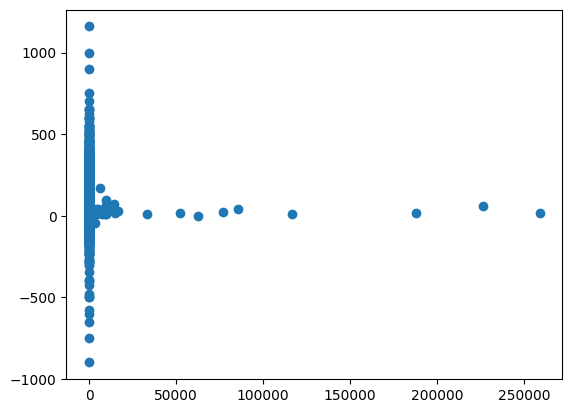

In [19]:
raw = (
    df.select(["trip_distance", "fare_amount"])
      .collect()
      .to_pandas()
)

import matplotlib.pyplot as plt

plt.scatter(raw["trip_distance"], raw["fare_amount"])
plt.show()

* Is this readable?
* Is this scalable?
* What happens if we use 12 months?

## Step 2. Distribution Vizualization (Fare amount)

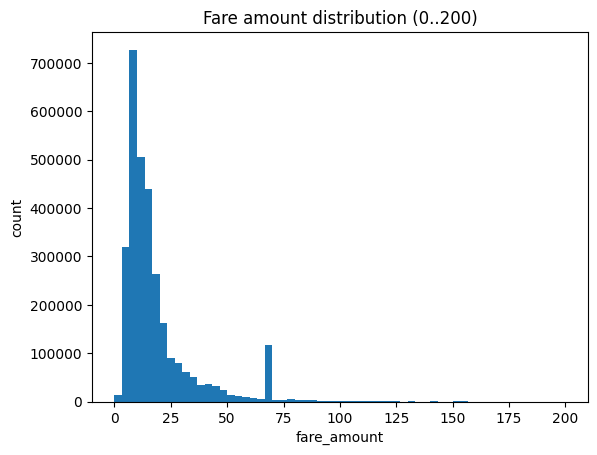

In [25]:
import matplotlib.pyplot as plt

# Keep only realistic values (you can discuss why thresholds exist)
fare = (
    df.select("fare_amount")
      .filter(pl.col("fare_amount").is_not_null())
      .filter(pl.col("fare_amount") > 0)
      .filter(pl.col("fare_amount") < 200)  # trim extreme tail for readability
      .collect()
      .to_pandas()
)

plt.hist(fare["fare_amount"], bins=60)
plt.title("Fare amount distribution (0..200)")
plt.xlabel("fare_amount")
plt.ylabel("count")
plt.show()

* Histograms aggregate automatically
* Binning compresses millions of values
* We are visualizing structure, not raw points

## Distribution Vizualization (Trip Distance)

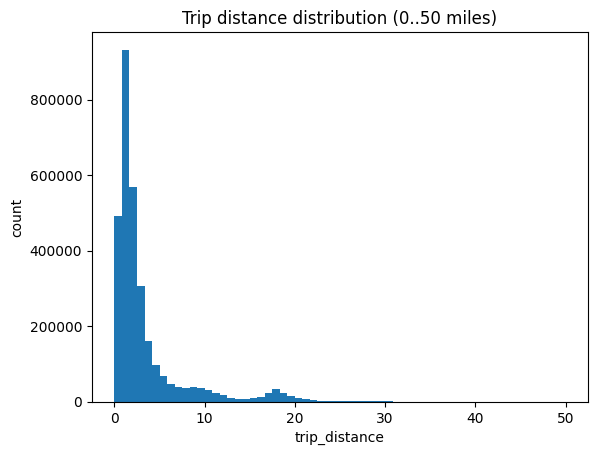

In [27]:
dist = (
    df.select("trip_distance")
      .filter(pl.col("trip_distance").is_not_null())
      .filter(pl.col("trip_distance") >= 0)
      .filter(pl.col("trip_distance") < 50)
      .collect()
      .to_pandas()
)

plt.hist(dist["trip_distance"], bins=60)
plt.title("Trip distance distribution (0..50 miles)")
plt.xlabel("trip_distance")
plt.ylabel("count")
plt.show()

## Step 3. Categorical Aggregation

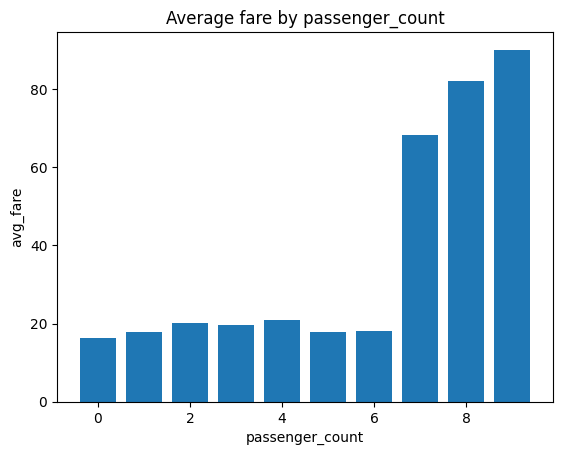

In [28]:
avg_fare_by_pass = (
    df.group_by("passenger_count")
      .agg([
          pl.len().alias("n_trips"),
          pl.mean("fare_amount").alias("avg_fare"),
          pl.median("fare_amount").alias("median_fare"),
      ])
      .sort("passenger_count")
      .collect()
      .to_pandas()
)

plt.bar(avg_fare_by_pass["passenger_count"], avg_fare_by_pass["avg_fare"])
plt.title("Average fare by passenger_count")
plt.xlabel("passenger_count")
plt.ylabel("avg_fare")
plt.show()

## Step 4. Time Aggregation

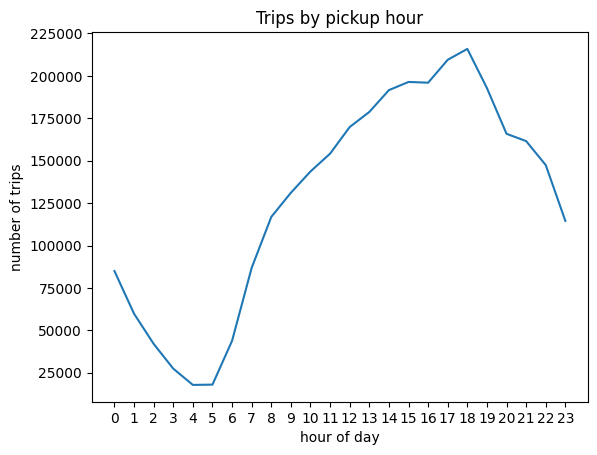

In [29]:
df_time = df.with_columns(
    pl.col("tpep_pickup_datetime").cast(pl.Datetime)
)

trips_per_hour = (
    df_time
    .group_by(pl.col("tpep_pickup_datetime").dt.hour().alias("hour"))
    .agg(pl.len().alias("n_trips"))
    .sort("hour")
    .collect()
    .to_pandas()
)

plt.plot(trips_per_hour["hour"], trips_per_hour["n_trips"])
plt.title("Trips by pickup hour")
plt.xlabel("hour of day")
plt.ylabel("number of trips")
plt.xticks(range(0, 24))
plt.show()

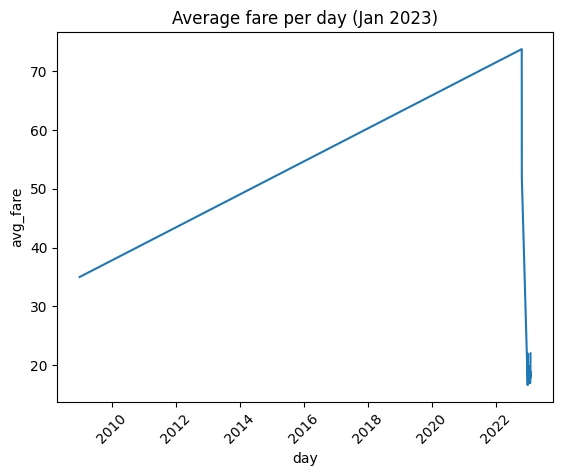

In [30]:
daily_avg_fare = (
    df_time
    .group_by(pl.col("tpep_pickup_datetime").dt.date().alias("day"))
    .agg(pl.mean("fare_amount").alias("avg_fare"))
    .sort("day")
    .collect()
    .to_pandas()
)

plt.plot(daily_avg_fare["day"], daily_avg_fare["avg_fare"])
plt.title("Average fare per day (Jan 2023)")
plt.xlabel("day")
plt.ylabel("avg_fare")
plt.xticks(rotation=45)
plt.show()

## Step 5. Relationship visualization: Distance vs fare

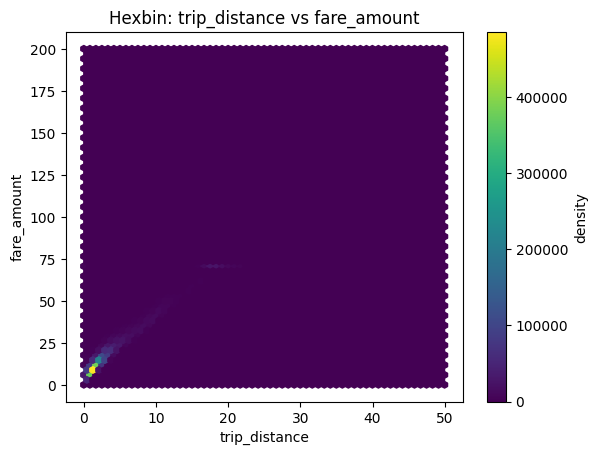

In [34]:
xy = (
    df.select(["trip_distance", "fare_amount"])
      .filter(pl.col("trip_distance").is_not_null())
      .filter(pl.col("fare_amount").is_not_null())
      .filter(pl.col("trip_distance") >= 0)
      .filter(pl.col("trip_distance") < 50)
      .filter(pl.col("fare_amount") > 0)
      .filter(pl.col("fare_amount") < 200)
      .collect()
      .to_pandas()
)

plt.hexbin(xy["trip_distance"], xy["fare_amount"], gridsize=60)
plt.colorbar(label="density")
plt.title("Hexbin: trip_distance vs fare_amount")
plt.xlabel("trip_distance")
plt.ylabel("fare_amount")
plt.show()

This is a hexbin plot showing the relationship between:
* x-axis: trip_distance (miles)
* y-axis: fare_amount (USD)
* color (density): number of trips falling into each hexagonal bin

Each hexagon:
* represents a small region in the (distance, fare) space
* color intensity shows how many trips fall into that region

#### Dense region (bottom-left)
The bright, dense area near:
* trip_distance ≈ 0–5
* fare_amount ≈ 0–20

This means:
* Most taxi trips are short
* Most fares are low
* This is expected for urban taxi traffic

## Step 6. Top 10 pickup zones

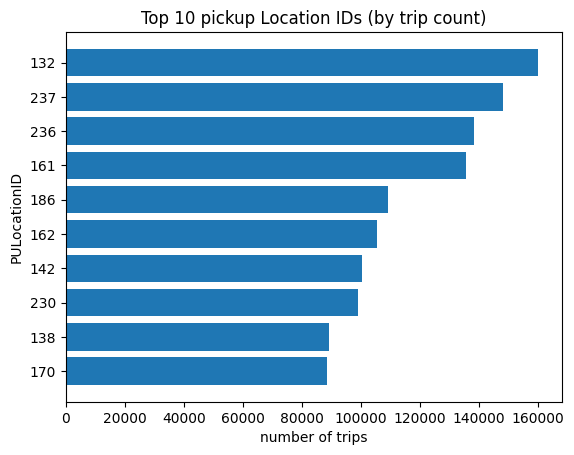

In [35]:
top_pickups = (
    df.group_by("PULocationID")
      .agg(pl.len().alias("n_trips"))
      .sort("n_trips", descending=True)
      .head(10)
      .collect()
      .to_pandas()
)

plt.barh(top_pickups["PULocationID"].astype(str), top_pickups["n_trips"])
plt.title("Top 10 pickup Location IDs (by trip count)")
plt.xlabel("number of trips")
plt.ylabel("PULocationID")
plt.gca().invert_yaxis()
plt.show()

## Useful reading: https://observablehq.com/blog/big-data-fast-data-visualizations